Imports

In [1]:
from data_classes import LAQNData, HealthData, MetData, IncomeData, LondonGeoData
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import geopandas as gpd
import numpy as np
import networkx as nx
import torch
import torch_geometric

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
species = "NO2"
region = "London"
NO2 = LAQNData(species, region)

In [3]:
income = IncomeData()

In [4]:
met = MetData("Heathrow")

In [5]:
geography = LondonGeoData()

Load the London shapefile for use in plotting:

In [6]:
# london_authorities_gdf = geography.download_and_log()
london_authorities_gdf = geography.read("london-local-authorities-raw")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl. Use `wandb login --relogin` to force relogin


In [10]:
london_authorities_gdf

,geometry,local_authority
0,"POLYGON ((0.13995 51.51336, 0.13907 51.51371, ...",Barking and Dagenham
1,"POLYGON ((-0.22266 51.56348, -0.22341 51.56407...",Barnet
2,"POLYGON ((0.11732 51.41316, 0.11694 51.41313, ...",Bexley
3,"POLYGON ((-0.25603 51.53390, -0.25612 51.53429...",Brent
4,"POLYGON ((0.01177 51.30020, 0.01170 51.30035, ...",Bromley
5,"POLYGON ((-0.18941 51.53501, -0.18954 51.53509...",Camden
6,"POLYGON ((-0.07274 51.51075, -0.07273 51.51059...",City of London
7,"POLYGON ((-0.09578 51.29955, -0.09553 51.29948...",Croydon
8,"POLYGON ((-0.37913 51.49614, -0.37913 51.49611...",Ealing
9,"POLYGON ((-0.09086 51.60885, -0.09088 51.60874...",Enfield


Load the resampled daily meteorological data:

In [ ]:
variables = ["temperature", "dew_point", "humidity", "precip", "wind_dir", "wind_speed", "peak_gust", "pressure"]
daily_met_df = met.read(variables, "met-resample")

Load the resampled daily NO2 data:

In [ ]:
# daily_NO2_df = NO2.read("laqn-resample")
# daily_NO2_df.head(5)

Load the resampled daily income data:

In [ ]:
daily_income_df = income.read("income-resample")

Resample the meteorological data using the income dates:

In [ ]:
# daily_met_df = met.resample_time_and_log(daily_income_df.index)

Rename the local authorities in the income metadata using the LAQN metadata:

In [ ]:
# income_metadata_df = income.rename_local_authority_districts_and_log(reference="use_LAQN")

Load the renamed income metadata:

In [ ]:
income_metadata_df = income.read("income-metadata")

Spatially aggregate the LAQN data at the local authority level, with implementation of the algorithm used in Schwartz, 2000:

In [ ]:
# aggregated_NO2_df = NO2.local_authority_aggregation_and_log()

Load the spatially aggregated LAQN data:

In [ ]:
aggregated_NO2_df = NO2.read("laqn-local-authority")

In [ ]:
print(aggregated_NO2_df.shape)
aggregated_NO2_df.plot()
plt.show()

Processing the London wards shapefile for use in this project. Move this code into data_classes at some point.

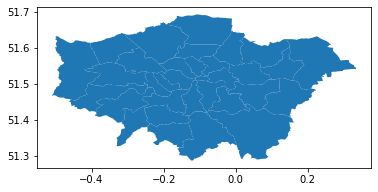

In [9]:
london_authorities_gdf.plot()
plt.show()

In [ ]:
def rename_local_authority_districts(df_to_rename, names_reference_list):
        local_authorities_to_rename = [item for item in set(df_to_rename.local_authority.tolist())]
        
        mismatches = []
        count = 0
        for local_authority in local_authorities_to_rename:
            if local_authority not in names_reference_list:
                mismatches.append(local_authority)
            else:
                count+=1
        print(f"Pass 1:\nMatched {count} out of {len(local_authorities_to_rename)} local authorities.")

        if mismatches:
            print("\nPass 2:\nSearching for matches...")
            mismatch_dict = {}
            search_letters = [local_authority[0:3] for local_authority in mismatches]
            ref_local_authorities_breakdown = [local_authority.split(" ") for local_authority in names_reference_list]
            for i in range(len(search_letters)):
                for local_authority in ref_local_authorities_breakdown:
                    for word in local_authority:
                        if search_letters[i] in word:
                            mismatch_dict.update({" ".join(local_authority): mismatches[i]})
            if mismatch_dict:
                print("Found matches (<reference_local_authority_name>: <local_authority_to_rename>):")
                print(mismatch_dict)
               
                for key in mismatch_dict.keys():
                    df_to_rename.replace({mismatch_dict[key]: key}, inplace=True)
                print("\nLocal authorities have been renamed.")
        return df_to_rename

In [ ]:
london_authorities_gdf = rename_local_authority_districts(london_authorities_gdf, income_metadata_df["local_authority"].tolist())

Set up the node connections:

In [ ]:
london_authorities_gdf["neighbours"] = None
edge_pairs = []

for index, row in london_authorities_gdf.iterrows():
    # get adjoining local authorities
    neighbours = london_authorities_gdf[london_authorities_gdf.geometry.touches(row.geometry)].local_authority.tolist()
    neighbours_index = london_authorities_gdf[london_authorities_gdf.geometry.touches(row.geometry)].index.tolist()

    # add names of neighbours as row value
    london_authorities_gdf.at[index, "neighbours"] = neighbours
    
    # add the neighbouring pair of indices to the edge_pairs list
    for neighbour in neighbours_index:
        edge_pairs.append([index, neighbour])

In [ ]:
edge_pairs = np.array(edge_pairs).transpose()

In [ ]:
edge_pairs.shape

In [ ]:
edge_index = torch.tensor(edge_pairs, dtype=torch.long)

In [ ]:
node_index = london_authorities_gdf.index.values.reshape(-1,1)
x = torch.tensor(node_index, dtype=torch.float)

In [ ]:
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(graph)

### Input feature processing to numpy arrays

Match up the date ranges for the income and NO2 data:

In [ ]:
def date_trim(df, start, end):
    df = df.loc[df.index >= start]
    df = df.loc[df.index <= end]
    return df

In [ ]:
start, end = daily_income_df.index.min(), daily_income_df.index.max()

aggregated_NO2_datetrim_df = date_trim(aggregated_NO2_df, start, end)
daily_met_datetrim_df = date_trim(daily_met_df, start, end)

In [ ]:
local_authority_list = [] 

for i in london_authorities_gdf.index:
    local_authority = london_authorities_gdf.iloc[i]["local_authority"]
    income_dataset_code = income_metadata_df.loc[income_metadata_df["local_authority"]==local_authority].index.values[0]
    daily_income_array = daily_income_df[income_dataset_code].values
    daily_NO2_array = aggregated_NO2_datetrim_df[local_authority].values
    node_array = np.array([daily_NO2_array, daily_income_array])
    local_authority_list.append(node_array)
input_array = np.array(local_authority_list)

In [ ]:
input_array.shape

In [ ]:
aggregated_NO2_df.columns